# ECG Analysis and Visualization

This notebook loads **pre-processed ECG/HRV features** and performs statistical analysis and visualization.

**Prerequisites**: 
- Run `process_ecg_data.py` first to generate processed HRV features
- Install R and required packages for statistical analysis:
  - `lmerTest` (for mixed-effects modeling)
  - `emmeans` (for estimated marginal means and pairwise comparisons)

**Data Source**: Loads from `data/processed/combined/ecg_features_all.csv`

## 1. Import Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Pre-Processed HRV Features

Load the combined HRV features file (generated by `process_ecg_data.py`):

In [9]:
# Load combined HRV features from processed data
features_file = Path('data/processed/combined/ecg_features_all.csv')

if not features_file.exists():
    raise FileNotFoundError(
        f"Processed features file not found: {features_file}\n"
        "Please run 'python process_ecg_data.py' first to generate the features."
    )

all_features_df = pd.read_csv(features_file)

print(f"✓ Loaded {len(all_features_df)} records from {all_features_df['participant'].nunique()} participants")
print(f"✓ Conditions: {sorted(all_features_df['condition'].unique())}")
print(f"✓ Feature columns: {len(all_features_df.columns)}")

✓ Loaded 1680 records from 38 participants
✓ Conditions: ['H', 'L', 'M']
✓ Feature columns: 90


## 3. Explore the Data

Display the first few rows and summary statistics:

In [10]:
# Display first few rows
print("First 10 rows of the dataset:")
display(all_features_df.head(10))

# Display summary statistics for key HRV features
key_features = ['heart_rate_mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN50', 
                'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'HRV_SD1', 'HRV_SD2']
available_features = [f for f in key_features if f in all_features_df.columns]

print("\nSummary statistics for key HRV features:")
display(all_features_df[available_features].describe())

# Display data types and missing values
print("\nData info:")
print(f"Shape: {all_features_df.shape}")
print(f"\nMissing values per column (showing top 10):")
missing_counts = all_features_df.isnull().sum().sort_values(ascending=False)
print(missing_counts.head(10))

First 10 rows of the dataset:


,window_index,t_start_sec,t_end_sec,heart_rate_mean,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,participant,condition,filename,HRV_DFA_alpha2,HRV_MFDFA_alpha2_Width,HRV_MFDFA_alpha2_Peak,HRV_MFDFA_alpha2_Mean,HRV_MFDFA_alpha2_Max,HRV_MFDFA_alpha2_Delta,HRV_MFDFA_alpha2_Asymmetry,HRV_MFDFA_alpha2_Fluctuation,HRV_MFDFA_alpha2_Increment
0,0,0.0,60.0,74.782692,803.111111,46.065341,43.596098,43.904048,0.057359,0.054284,796.0,53.3736,0.067052,69.0,1.056639,760.0,836.0,26.388889,70.833333,720.0,912.0,9.000000,78.1250,0.011367,0.036140,0.001125,0.048631,0.314517,0.233728,0.743132,-3.320366,31.044850,57.133259,0.543376,5572.222261,1.840346,4.452999,420.579810,0.569444,0.579710,0.950000,0.076923,50.598802,50.565517,50.633353,47.826087,0.488736,0.511264,21.704509,22.199099,0.585617,0.414383,43.721567,36.778170,0.563531,0.436469,34.515657,30.376256,0.640734,1.910623,0.816221,1.596046,-1.321548,-2.308274,-0.091848,0.005868,0.423820,0.417414,2.047693,4.789368,1.448987,1.070301,1.017092,1.450866,1.897647,1.934095,3.786735,1.114014,3208,H,3208_ecg_session03.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,30.0,90.0,73.924777,812.164384,48.955483,42.266351,42.559983,0.060278,0.052042,808.0,59.3040,0.073396,72.0,1.158261,765.6,856.8,27.397260,72.602740,720.0,908.0,12.166667,78.1250,0.004233,0.019414,0.000762,0.024408,0.218026,0.173413,0.795376,-3.941782,30.094452,62.794084,0.479256,5936.835940,2.086567,4.480525,524.096201,0.602740,0.614286,0.953488,0.076923,50.670641,50.666708,50.673369,50.000000,0.484389,0.515611,20.946612,21.611160,0.447792,0.552208,42.020088,46.662718,0.454629,0.545371,33.199762,36.362422,0.683869,1.941716,0.662085,1.606577,-1.467985,-2.377911,-0.013578,0.004084,0.370468,0.496173,1.665008,5.158534,1.353825,1.043702,0.746691,0.830809,1.958955,1.951883,4.168317,1.017505,3208,H,3208_ecg_session03.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,60.0,120.0,75.585707,794.108108,62.619435,42.285397,42.549997,0.078855,0.053249,790.0,80.0604,0.101342,108.0,1.480876,736.0,852.0,29.729730,70.270270,684.0,908.0,10.571429,78.1250,0.003926,0.014664,0.000441,0.019031,0.267735,0.206299,0.770536,-4.222377,30.087392,82.988272,0.362550,7844.244727,2.758241,4.601521,915.606555,0.581081,0.591549,0.928571,0.076923,47.897898,47.740791,48.049964,53.521127,0.469110,0.530890,20.620917,21.936778,0.423328,0.576672,53.995190,63.020415,0.428653,0.571347,40.869932,47.184717,0.648050,0.593439,0.778460,0.780783,0.709455,0.109994,-0.496085,0.000168,0.025783,0.721206,1.634131,5.116293,1.172167,1.116714,1.107217,1.130518,1.610094,1.917651,3.709976,0.923027,3208,H,3208_ecg_session03.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,90.0,150.0,77.258482,776.736842,59.990081,44.723745,45.024790,0.077233,0.057579,760.0,62.2692,0.081933,80.0,1.341347,720.0,836.0,30.263158,72.368421,684.0,920.0,7.600000,54.6875,0.002347,0.009406,0.000459,0.012213,0.249543,0.192194,0.770186,-4.666387,31.837334,79.158129,0.402199,7917.390952,2.486330,4.605552,787.253017,0.578947,0.583333,0.952381,0.071429,49.858357,49.863836,49.853717,47.222222,0.480802,0.519198,22.076036,22.940581,0.513679,0.486321,56.733737,55.202287,0.509101,0.490899,43.046883,42.270337,0.786610,0.715294,0.954338,0.986138,0.588016,-0.075687,-0.455542,0.000250,0.040630,0.472239,1.466337,4.99


Summary statistics for key HRV features:


,heart_rate_mean,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_LF,HRV_HF,HRV_LFHF,HRV_SD1,HRV_SD2
count,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000
mean,87.263360,717.091338,114.852374,128.881113,22.314362,0.033140,0.039446,1.803334,91.735928,131.202097
std,14.747560,123.846417,202.448494,252.381074,29.598466,0.016155,0.035218,2.044572,179.864066,222.737195
min,39.605375,419.942857,4.662776,3.819455,0.000000,0.001237,0.000374,0.042877,2.713957,5.867693
25%,75.074846,632.765957,26.624847,17.822599,0.000000,0.018796,0.012814,0.515730,12.672505,34.268878
50%,87.977385,689.023256,37.050762,29.429720,6.896552,0.033589,0.026467,1.049650,20.957054,47.345545
75%,96.393013,804.270270,55.762609,47.942684,30.034247,0.047585,0.056894,2.216582,34.127193,71.683777
max,150.941150,1595.666667,1732.297730,2451.744541,95.061728,0.070332,0.168672,16.622653,1750.890366,1772.711709



Data info:
Shape: (1680, 90)

Missing values per column (showing top 10):
HRV_MFDFA_alpha2_Fluctuation    1650
HRV_MFDFA_alpha2_Width          1650
HRV_DFA_alpha2                  1650
HRV_MFDFA_alpha2_Peak           1650
HRV_MFDFA_alpha2_Mean           1650
HRV_MFDFA_alpha2_Max            1650
HRV_MFDFA_alpha2_Delta          1650
HRV_MFDFA_alpha2_Asymmetry      1650
HRV_MFDFA_alpha2_Increment      1650
window_index                       0
dtype: int64


## 4. Condition-Level Summary Statistics

Compute mean and standard error for each metric by condition:

In [11]:
# Compute summary statistics by condition for key HRV features
summary_features = {
    'heart_rate_mean': ['mean', 'std', 'sem'],
    'HRV_MeanNN': ['mean', 'std', 'sem'],
    'HRV_SDNN': ['mean', 'std', 'sem'],
    'HRV_RMSSD': ['mean', 'std', 'sem'],
    'HRV_pNN50': ['mean', 'std', 'sem'],
    'HRV_LF': ['mean', 'std', 'sem'],
    'HRV_HF': ['mean', 'std', 'sem'],
    'HRV_LFHF': ['mean', 'std', 'sem'],
    'HRV_SD1': ['mean', 'std', 'sem'],
    'HRV_SD2': ['mean', 'std', 'sem']
}

# Filter to features that exist
summary_features = {k: v for k, v in summary_features.items() if k in all_features_df.columns}

summary_stats = all_features_df.groupby('condition').agg(summary_features).round(3)

print("Summary Statistics by Condition:")
display(summary_stats)

# Also show counts by participant and condition
print("\nRecords per Participant and Condition:")
record_counts = all_features_df.groupby(['participant', 'condition']).size().unstack(fill_value=0)
display(record_counts.describe())

Summary Statistics by Condition:


heart_rate_mean                HRV_MeanNN                 HRV_SDNN  \
                     mean     std    sem       mean      std    sem     mean   
condition                                                                      
H                  85.335  15.156  0.635    738.376  145.143  6.079  138.388   
L                  88.899  14.033  0.596    699.796  111.057  4.714   94.567   
M                  87.609  14.821  0.629    712.526  108.292  4.597  110.967   

                           HRV_RMSSD                  HRV_pNN50          \
               std     sem      mean      std     sem      mean     std   
condition                                                                 
H          248.224  10.397   157.637  309.150  12.949    24.223  31.274   
L          166.257   7.057   104.872  209.016   8.872    20.183  28.064   
M          179.699   7.628   123.357  223.014   9.466    22.486  29.233   

                 HRV_LF               HRV_HF               HRV_LFHF         \
             sem   mean    std    sem   mean    std    sem     mean    std   
condition                                                                    
H          1.310  0.032  0.016  0.001  0.040  0.036  0.001    1.768  2.126   
L          1.191  0.034  0.017  0.001  0.038  0.036  0.002    1.926  1.993   
M          1.241  0.033  0.016  0.001  0.040  0.034  0.001    1.717  2.008   

                  HRV_SD1                  HRV_SD2                   
             sem     mean      std    sem     mean      std     sem  
condition                                                            
H          0.089  112.290  220.558  9.238  156.556  271.267  11.362  
L          0.085   74.617  148.859  6.319  108.968  183.318   7.781  
M          0.085   87.746  158.681  6.736  127.397  200.008   8.490


Records per Participant and Condition:


condition,H,L,M
count,38.0,38.000000,38.000000
mean,15.0,14.605263,14.605263
std,0.0,2.433321,2.433321
min,15.0,0.000000,0.000000
25%,15.0,15.000000,15.000000
50%,15.0,15.000000,15.000000
75%,15.0,15.000000,15.000000
max,15.0,15.000000,15.000000


## 5. Add Session Order Information for Statistical Analysis

Load participant info and add session order variables needed for mixed effects models:

In [12]:
# Load participant info to get session order (using pose utilities)
import sys
sys.path.append('..')
from Pose.utils.io_utils import load_participant_info_file

# Load participant info file
participant_info_path = load_participant_info_file()
participant_info = pd.read_csv(participant_info_path)

print(f"✓ Loaded participant info from: {participant_info_path}")

# Create session_order column (e.g., "LMH", "LHM")
if {"session01", "session02", "session03"}.issubset(participant_info.columns):
    participant_info["session_order"] = (
        participant_info["session01"].str[0] +
        participant_info["session02"].str[0] +
        participant_info["session03"].str[0]
    )
    
    # Map session_order to numeric values
    session_order_numeric_map = {
        "LMH": 1, 
        "LHM": 2, 
        "MLH": 3, 
        "MHL": 4, 
        "HLM": 5, 
        "HML": 6
    }
    
    participant_info["session_order_numeric"] = participant_info["session_order"].map(session_order_numeric_map)
    
    # Create a mapping from participant ID to session_order_numeric
    session_order_map = participant_info.set_index("Participant ID")["session_order_numeric"].to_dict()
    
    # Add session_order_numeric to all_features_df
    all_features_df["session_order_numeric"] = all_features_df["participant"].astype(int).map(session_order_map)
    
    # Add window_index column for compatibility with stats_figures.py
    # ECG features are session-level (not windowed), so set to 0 for all records
    all_features_df["window_index"] = 0
    
    print(f"✓ Added session order information")
    print(f"  Unique session orders: {sorted(participant_info['session_order'].unique())}")
    print(f"  Session order distribution:")
    print(participant_info['session_order'].value_counts().sort_index())
    print(f"✓ Added window_index column (set to 0 for session-level ECG data)")
else:
    raise ValueError("Participant info file missing required columns: session01, session02, session03")

✓ Loaded participant info from: D:\Onedrive\Macquarie University\Complexity in Action - Mind and Interaction Dynamics\PNAS-MATB\participant_info.csv
✓ Added session order information
  Unique session orders: ['---', 'LHM', 'LMH']
  Session order distribution:
session_order
---     1
LHM    24
LMH    25
Name: count, dtype: int64
✓ Added window_index column (set to 0 for session-level ECG data)


## 6. Statistical Analysis Using Linear Mixed Effects Models

Run mixed effects models and create visualizations for key HRV metrics:

In [13]:
import sys
sys.path.append('..')  # Add parent directory
from stats_utils.stats_figures import run_rpy2_lmer, barplot_ax

# Define relevant metrics and labels for statistical analysis
metrics = [
    ("heart_rate_mean", "Mean Heart Rate (bpm)"),
    ("HRV_MeanNN", "Mean NN Interval (ms)"),
    ("HRV_SDNN", "SDNN (ms)"),
    ("HRV_RMSSD", "RMSSD (ms)"),
    ("HRV_pNN50", "pNN50 (%)"),
    ("HRV_LF", "LF Power"),
    ("HRV_HF", "HF Power"),
    ("HRV_LFHF", "LF/HF Ratio"),
    ("HRV_SD1", "SD1 (Poincaré)"),
    ("HRV_SD2", "SD2 (Poincaré)")
]

# Filter to metrics that exist in the data
metrics = [(m, l) for m, l in metrics if m in all_features_df.columns]

print(f"✓ Imported statistical utilities")
print(f"  Running analysis on {len(metrics)} HRV metrics")

✓ Imported statistical utilities
  Running analysis on 10 HRV metrics


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Mean Heart Rate (bpm)
Means for heart_rate_mean:
  H: 85.335
  L: 88.899
  M: 87.609

=== Mean Heart Rate (bpm) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 11781.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8377 -0.2304 -0.0209  0.2232  5.8328 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 173.44   13.170  
 Residual                    58.65    7.658  
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             79.20968    7.18824   35.92909  11.019 4.48e-13 ***
condition.L             -1.95291    0.32502 1640.80187  -6.009 2.30e-09 ***
condition.Q             -0.07422    0.32505 1640.20211  -0.228    0.819    
session_order

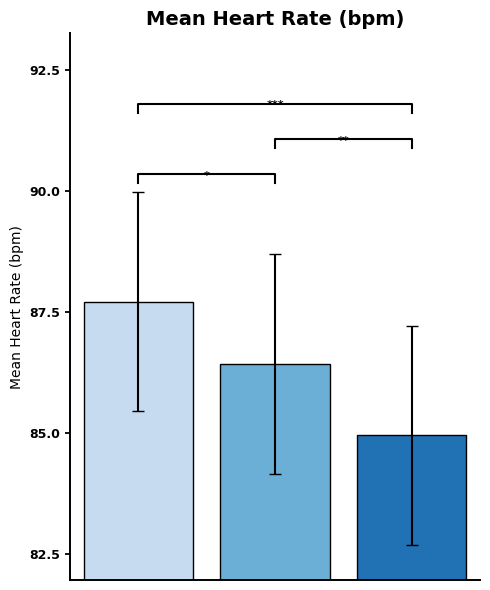

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Mean NN Interval (ms)
Means for HRV_MeanNN:
  H: 738.376
  L: 699.796
  M: 712.526

=== Mean NN Interval (ms) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 19083.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5035 -0.2224 -0.0097  0.1987 11.6242 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 14796    121.64  
 Residual                    4566     67.58  
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            791.82770   66.36800   35.66465  11.931 5.22e-14 ***
condition.L             18.15004    2.86805 1640.46686   6.328 3.19e-10 ***
condition.Q              0.08439    2.86829 1639.91346   0.029    0.977    
session_order_n

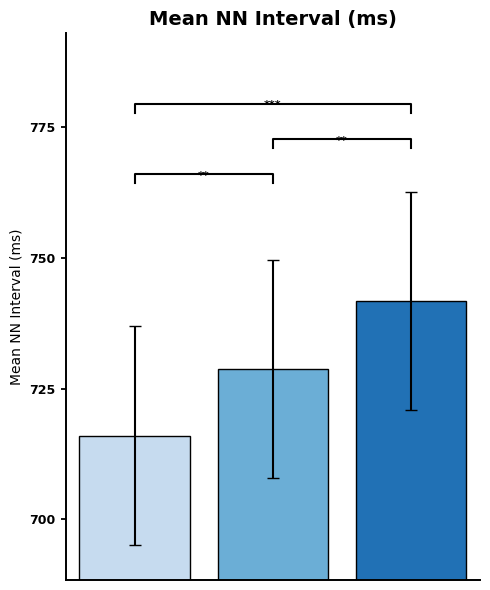

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



SDNN (ms)
Means for HRV_SDNN:
  H: 138.388
  L: 94.567
  M: 110.967

=== SDNN (ms) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 19704.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0068 -0.1326 -0.0409  0.1071 12.3567 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 53136    230.51  
 Residual                    6483     80.51  
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            172.198    125.484   35.831   1.372 0.178511    
condition.L             12.465      3.417 1640.154   3.647 0.000273 ***
condition.Q             -6.194      3.418 1639.931  -1.812 0.070107 .  
session_order_numeric  -25.394     75.848   35.824  -0.335

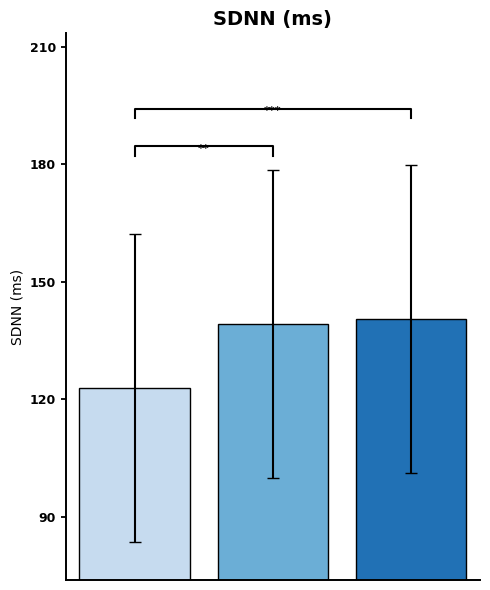

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



RMSSD (ms)
Means for HRV_RMSSD:
  H: 157.637
  L: 104.872
  M: 123.357

=== RMSSD (ms) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 20159.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8277 -0.0957 -0.0521  0.1149 11.7633 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 84403    290.52  
 Residual                    8471     92.04  
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            201.736    158.111   35.863   1.276 0.210187    
condition.L             14.159      3.907 1640.130   3.624 0.000299 ***
condition.Q             -6.919      3.907 1639.946  -1.771 0.076748 .  
session_order_numeric  -32.481     95.570   35.858  -0

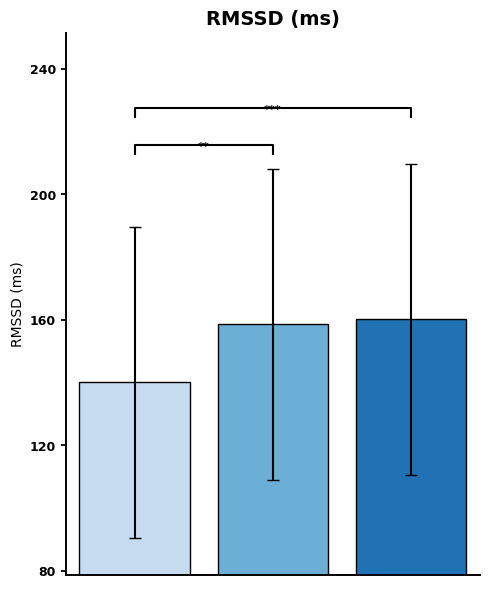

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



pNN50 (%)
Means for HRV_pNN50:
  H: 24.223
  L: 20.183
  M: 22.486

=== pNN50 (%) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 11377.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.9337 -0.3110 -0.0682  0.3124  4.1901 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 933.21   30.548  
 Residual                    44.19    6.648  
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             22.1631    16.6145   35.9899   1.334  0.19060    
condition.L              1.6653     0.2822 1640.1163   5.902 4.36e-09 ***
condition.Q             -0.9192     0.2822 1640.0293  -3.258  0.00115 ** 
session_order_numeric    0.7962    10.0428   35.987

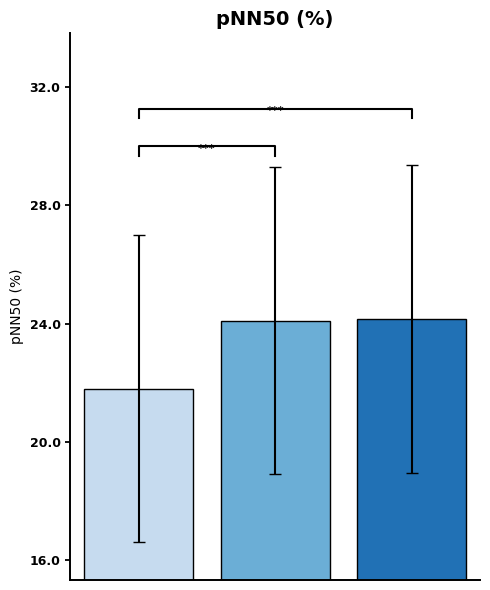

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



LF Power
Means for HRV_LF:
  H: 0.032
  L: 0.034
  M: 0.033

=== LF Power (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9243.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.46538 -0.83054  0.01591  0.80563  2.41520 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000409 0.006395
 Residual                   0.0002213 0.014875
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.230e-02  3.697e-03  3.654e+01   8.738 1.77e-10 ***
condition.L           -1.508e-03  6.303e-04  1.649e+03  -2.393   0.0168 *  
condition.Q           -5.478e-05  6.310e-04  1.643e+03  -0.087   0.9308    
session_order_numeric  5.425e-04  2.23

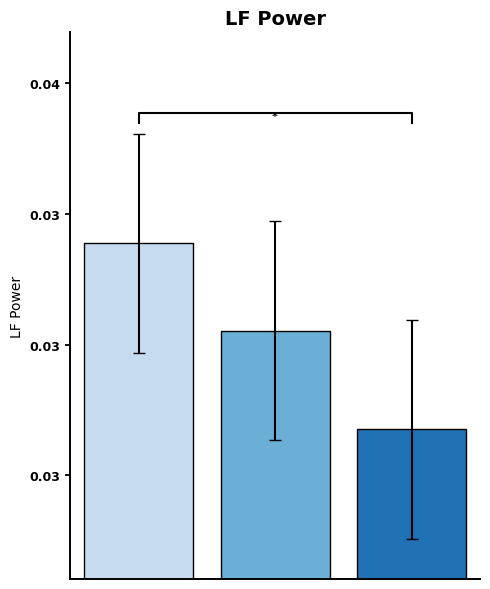

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



HF Power
Means for HRV_HF:
  H: 0.040
  L: 0.038
  M: 0.040

=== HF Power (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -7753.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9000 -0.5384 -0.1285  0.4754  4.8328 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0007490 0.02737 
 Residual                   0.0005161 0.02272 
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)            3.483e-02  1.500e-02  3.611e+01   2.322   0.0260 *
condition.L            1.672e-03  9.640e-04  1.642e+03   1.735   0.0829 .
condition.Q           -3.241e-04  9.642e-04  1.641e+03  -0.336   0.7368  
session_order_numeric  2.908e-03  9.066e-03  3.608e+01  

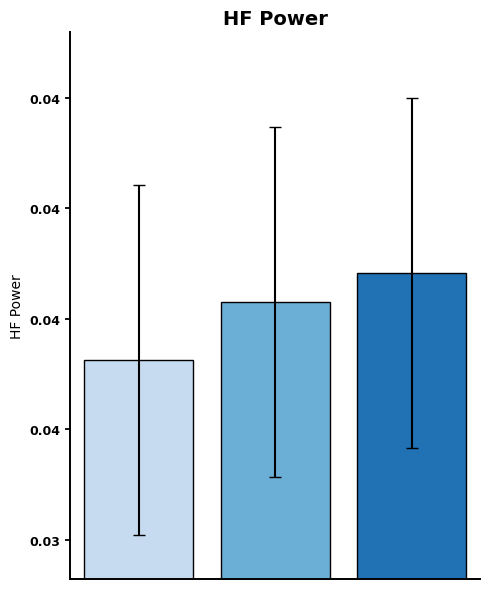

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



LF/HF Ratio
Means for HRV_LFHF:
  H: 1.768
  L: 1.926
  M: 1.717

=== LF/HF Ratio (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 6277.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4321 -0.4021 -0.1358  0.2103  7.4958 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.001    1.414   
 Residual                   2.255    1.502   
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)              2.33172    0.77940   36.10905   2.992  0.00498 **
condition.L             -0.13652    0.06371 1642.75676  -2.143  0.03229 * 
condition.Q              0.09207    0.06373 1640.94609   1.445  0.14876   
session_order_numeric   -0.31940    0.47094   36

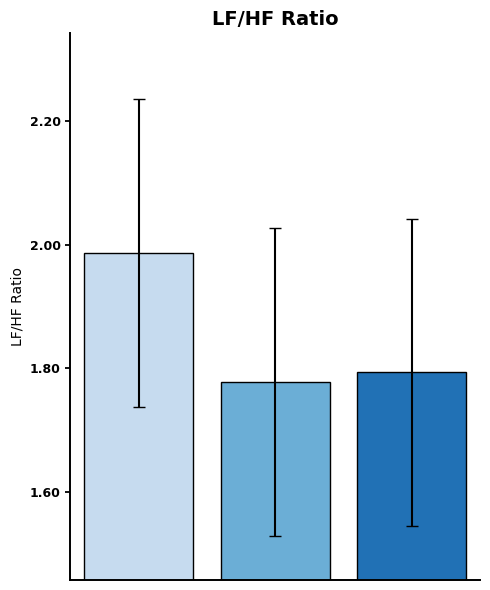

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



SD1 (Poincaré)
Means for HRV_SD1:
  H: 112.290
  L: 74.617
  M: 87.746

=== SD1 (Poincaré) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 19032.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8495 -0.0952 -0.0519  0.1145 11.7462 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 42939    207.22  
 Residual                    4323     65.75  
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            144.061    112.774   35.862   1.277 0.209660    
condition.L             10.083      2.791 1640.130   3.613 0.000312 ***
condition.Q             -4.898      2.791 1639.945  -1.755 0.079456 .  
session_order_numeric  -23.371     68.166   35.857

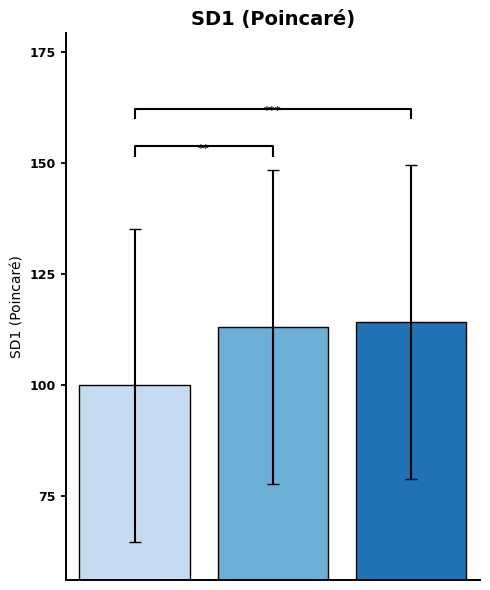

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



SD2 (Poincaré)
Means for HRV_SD2:
  H: 156.556
  L: 108.968
  M: 127.397

=== SD2 (Poincaré) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 20331.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0643 -0.1396 -0.0370  0.1047 14.1989 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 61120    247.23  
 Residual                    9472     97.32  
Number of obs: 1680, groups:  participant_id, 38

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            189.784    134.637   35.791   1.410 0.167289    
condition.L             14.023      4.131 1640.200   3.395 0.000703 ***
condition.Q             -6.951      4.131 1639.918  -1.683 0.092656 .  
session_order_numeric  -25.528     81.380   35.7

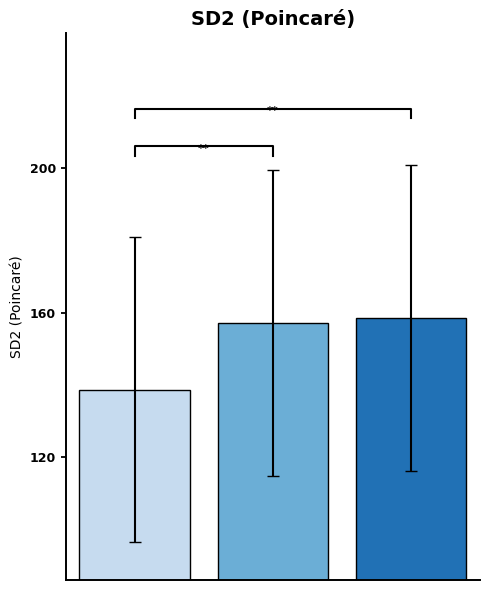


✓ Statistical analysis complete!


In [14]:
# Run statistical analysis for key HRV metrics
for metric, label in metrics:
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    
    # Run mixed effects model and get stats
    pairwise_p, means, cis = run_rpy2_lmer(
        all_features_df, metric, label
    )
    
    # Prepare data for plotting
    conds = ["L", "M", "H"]
    mean_vals = [means.get(c, float('nan')) for c in conds]
    sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]  # 95% CI to SEM
    pvals = [
        pairwise_p.get(("L", "M"), 1.0), 
        pairwise_p.get(("L", "H"), 1.0), 
        pairwise_p.get(("M", "H"), 1.0)
    ]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(5, 6))
    barplot_ax(ax, mean_vals, sems, pvals, ylabel=label, metric_name=metric)
    ax.set_title(label, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

print("\n✓ Statistical analysis complete!")